# CBO Applied to RL

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.colors as colors
%matplotlib inline
plt.style.use('default')
# plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.dpi'] = 120

In [2]:
# hacky way of toggling between showing/hiding progress bar

# show
from tqdm.auto import tqdm, trange
# hide
# trange = lambda x, leave=None, desc=None: range(x)
# tqdm = lambda x, leave=None, desc=None: x

In [3]:
def sample_trajectory(s_0, α, σ, ϵ, m):
    """
    samples trajectory of a particle following dSₜ = α(t) dt + σ(t) Wₜ, approximated by discrete units of time.
    
    parameters:
    s_0  : Starting state of particle
    α    : Drift function
    σ    : Noise scale function
    ϵ    : Step size
    m    : Number of steps to sample
    
    returns:
    S:   torch.tensor of sampled trajectory, with size (m, *s_0.size())
    """
    s_0_size = s_0.size()
    S = torch.zeros(m, *s_0_size)
    S[0] = s_0
    for i in range(m-1):
        S[i+1] = S[i]+α(S[i])*ϵ+σ(S[i])*torch.sqrt(ϵ)*torch.normal(mean=torch.zeros(*s_0_size))
    return S

In [4]:
def gen_batches(N, M, Rem):
    """
    generate random batches of indices, keeping track of remainders
    
    parameters:
    N   : number of elements to choose from
    M   : size of batches
    Rem : previous remainder
    
    returns:
    B   : tensor of batches, of size q,M 
    Rem : new remainder
    """
    P = torch.randperm(N)
    if Rem.size()[0] > 0:
        I = torch.cat((Rem, P), 0)
    else:
        I = P
    q = int(np.floor((P.size()[0]+Rem.size()[0])/M))
    B = I[:(q*M)].view(q, M)
    Rem = I[(q*M):]
    return B, Rem

## $Q$-evaluation and control, continuous state space (4.1.)

### Outline

- MDP with a continuous state space $\mathbb S = \{s \in (0, 2\pi]\}$.
- Dynamics described by 

$$
\begin{aligned}
&\Delta s_{m} = a_m\epsilon + \sigma \sqrt{\epsilon} Z_m\\
&a_m \in\mathbb A = \{\pm 1\}\\
&a_m\sim \pi(\cdot|s_{m-1})\\
&\varepsilon = \frac{2\pi}{32}\\
&\sigma = 0.2\\
&r(s_{m+1},s_{m},a_m) = \sin(s_{m+1})+1
\end{aligned}
$$

- 3 layer FCNN, $Q^\pi(s,a;\theta)$. Two hidden layers with $\cos$ activation function, and each hidden layer contains 50 neurons. Output layer of size $|\mathbb A|$.

### $Q$-evaluation

Estimating $Q^\pi$ for fixed policy $\pi(a|s)=1/2 + a \sin(s)/5$.
$$j^{eval}(s_m, a_m, s_{m+1};\theta) = r(s_{m+1}, s_m, a_m)  + \gamma \int Q^\pi(s_{m+1},a;\theta)\pi(a|s_{m+1})da - Q^\pi(s_m,a_m;\theta)$$

In [5]:
from torch.distributions.categorical import Categorical 

In [6]:
π = lambda a, s: 1/2 + a*torch.sin(s)/5
σ = 0.2
ϵ = 2.*np.pi/32.
s_0 = torch.tensor([0.])
r = lambda s: torch.sin(s)+1
a_s = torch.tensor([-1.,1.])

In [7]:
def sample_policy(s_0, π, σ, ϵ, a_s, m):
    """
    samples trajectory of a particle following dSₜ = a(t) dt + σ(t) Wₜ, approximated by discrete units of time,
    where a ~ π(a|s)
    
    parameters:
    s_0  : Starting state of particle
    π    : Policy, function of a,s
    σ    : Noise scale
    ϵ    : Step size
    a_s  : Action set
    m    : Number of steps to sample
    
    returns:
    S    : torch.tensor of sampled trajectory, with size (m, *s_0.size())
    """
    s_0 = s_0.view(s_0.size()[0],-1)
    s_0_size = s_0.size()
    S = torch.zeros(m,*s_0_size)
    S[0] = s_0
    A_idx = torch.zeros(m,s_0_size[0])
    for i in trange(m-1):
        for j, s in enumerate(S[i]):
            A_idx[i,j] = Categorical(probs=π(a_s,s)).sample()
            a = A_idx[i,j]*2. - 1.
            S[i+1,j] = s+a*ϵ+σ*np.sqrt(ϵ)*torch.normal(mean=torch.zeros_like(s))
    return S.view(-1,1), A_idx.view(-1,1)

In [9]:
# S,A_idx = sample_policy(s_0, π, σ, ϵ, a_s, int(1e6))
# R = r(S) 
# S_long, A_idx_long = sample_policy(s_0, π, σ, ϵ, a_s, int(1e7))
# R_long = r(S_long) 

In [10]:
# torch.save(S_long, 'S_long_1.pt')
# torch.save(A_idx_long, 'A_idx_long_1.pt')
# torch.save(R_long, 'R_long_1.pt')
# torch.save(S, 'S_1.pt')
# torch.save(A_idx, 'A_idx_1.pt')
# torch.save(R, 'R_1.pt')

In [10]:
S_long = torch.load('S_long_1.pt')
R_long = torch.load('R_long_1.pt')
A_idx_long = torch.load('A_idx_long_1.pt')
S = torch.load('S_1.pt')
R = torch.load('R_1.pt')
A_idx = torch.load('A_idx_1.pt')

In [15]:
# plt.plot(S,".",markersize=0.2);
# plt.xlabel(r"$i$");
# plt.ylabel(r"$s_i$");
# plt.show();
# plt.plot(torch.remainder(S,2*np.pi),".",markersize=0.2, alpha = 0.2);
# plt.xlabel(r"$i$");
# plt.ylabel(r"$s_i$");
# plt.show();
# plt.plot(R,".",markersize=0.3,alpha=0.2);
# plt.xlabel(r"$i$");
# plt.ylabel(r"$R(s_i)$");
# plt.show();
# plt.plot(A_idx.view(-1),torch.remainder(S,2*np.pi).view(-1),".",markersize=0.3,alpha=0.2);
# plt.xlabel(r"$a_i$");
# plt.ylabel(r"$s_i$");
# plt.show();

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 50) 
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = torch.cat((torch.sin(x), torch.cos(x)), 1)
        x = torch.cos(self.fc1(x))
        x = torch.cos(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
def comp(Q_net,Q_net_comp,x_ls, n):
    diff = Q_net(x_ls)-Q_net_comp(x_ls)
    return np.sqrt(2*np.pi/n)*torch.norm(diff-torch.mean(diff,axis=0))
def comp_0(V_net,V_net_comp,x_ls, n):
    diff = Q_net(x_ls)-Q_net_comp(x_ls)
    return np.sqrt(2*np.pi/n)*torch.norm(diff)

#### SGD

In [18]:
def Q_eval_SGD_DS(Q_net, M, epochs,γ,τ_k, S, A_idx, R, Q_net_comp=None, n=100):
    Rem = torch.tensor([])
    N = S.size()[0]
    if Q_net_comp:
        x_ls = torch.linspace(0,2*np.pi,n+1)[:-1].view(-1,1)
        e = [comp(Q_net,Q_net_comp,x_ls, n)]
    for k in trange(epochs, leave=False,desc="Epoch"):
        B, Rem = gen_batches(N-1,M, Rem)
        τ = τ_k(k)
        for i,B_θ in enumerate(tqdm(B,leave=False,desc="Batch")): 
            s = S[B_θ]
            r = R[B_θ].view(-1)
            a_idx = A_idx[B_θ].type(torch.LongTensor).view(-1)
            s_1 = S[B_θ+1]
            q = Q_net(s)[np.arange(M),a_idx]
            j = r + γ*torch.sum(Q_net(s_1)*π(a_s,s_1),axis=1) - q
            Q_net.zero_grad()
            j.backward(j)
            with torch.no_grad():
                for param in Q_net.parameters():
                    param -= τ/M*param.grad
            if Q_net_comp:
                e.append(comp(Q_net,Q_net_comp,x_ls, n))
    if Q_net_comp:
        return Q_net, torch.tensor(e)
    else:
        return Q_net

In [19]:
def Q_eval_SGD_UR(Q_net, M, epochs,γ,τ_k, S, A_idx, R, a_s, π,σ,ϵ, Q_net_comp=None, n=100):
    Rem = torch.tensor([])
    N = S.size()[0]
    if Q_net_comp:
        x_ls = torch.linspace(0,2*np.pi,n+1)[:-1].view(-1,1)
        e = [comp(Q_net,Q_net_comp,x_ls, n)]
    for k in trange(epochs, leave=False,desc="Epoch"):
        B, Rem = gen_batches(N-1,M, Rem)
        τ = τ_k(k)
        for i,B_θ in enumerate(tqdm(B,leave=False,desc="Batch")): 
            s = S[B_θ]
            r = R[B_θ].view(-1)
            a_idx = A_idx[B_θ].type(torch.LongTensor).view(-1)
            s_1 = S[B_θ+1]
            â = torch.tensor([Categorical(probs=π_).sample() for π_ in π(a_s,s)]).view(*s.size())*2 - 1
            ŝ_1 = s+â*ϵ+σ*np.sqrt(ϵ)*torch.normal(mean=torch.zeros_like(s))
            q = Q_net(s)[np.arange(M),a_idx]
            j = r + γ*torch.sum(Q_net(s_1)*π(a_s,s_1),axis=1) - q
            ĵ = r + γ*torch.sum(Q_net(ŝ_1)*π(a_s,ŝ_1),axis=1) - q
            Q_net.zero_grad()
            ĵ.backward(j)
            with torch.no_grad():
                for param in Q_net.parameters():
                    param -= τ/M*param.grad
            if Q_net_comp:
                e.append(comp(Q_net,Q_net_comp,x_ls, n))
    if Q_net_comp:
        return Q_net, torch.tensor(e)
    else:
        return Q_net

In [20]:
def Q_eval_SGD_BFF(Q_net, M, epochs,γ,τ_k, S, A_idx, R, Q_net_comp=None, n=100):
    Rem = torch.tensor([])
    N = S.size()[0]
    if Q_net_comp:
        x_ls = torch.linspace(0,2*np.pi,n+1)[:-1].view(-1,1)
        e = [comp(Q_net,Q_net_comp,x_ls, n)]
    for k in trange(epochs, leave=False,desc="Epoch"):
        B, Rem = gen_batches(N-2,M, Rem)
        τ = τ_k(k)
        for i,B_θ in enumerate(tqdm(B,leave=False,desc="Batch")): 
            s = S[B_θ]
            r = R[B_θ].view(-1)
            a_idx = A_idx[B_θ].type(torch.LongTensor).view(-1)
            s_1 = S[B_θ+1]
            s_2 = S[B_θ+2]
            s̃_1 = s+s_2-s_1
            q = Q_net(s)[np.arange(M),a_idx]
            j = r + γ*torch.sum(Q_net(s_1)*π(a_s,s_1),axis=1) - q
            j̃ = r + γ*torch.sum(Q_net(s̃_1)*π(a_s,s̃_1),axis=1) - q
            Q_net.zero_grad()
            j̃.backward(j)
            with torch.no_grad():
                for param in Q_net.parameters():
                    param -= τ/M*param.grad
            if Q_net_comp:
                e.append(comp(Q_net,Q_net_comp,x_ls, n))
    if Q_net_comp:
        return Q_net, torch.tensor(e)
    else:
        return Q_net

In [21]:
Q_star = Net()
M = int(1e4)
epochs = 3
γ = 0.9
τ_k = lambda k: 0.025*0.95**k
Q_star = Q_eval_SGD_UR(Q_star, M, epochs,γ,τ_k, S_long, A_idx_long, R_long, a_s, π,σ,ϵ)

In [22]:
M = int(1e4)
epochs = 25
τ_k = lambda k: 0.08*0.9**k

In [23]:
Q_UR = Net()
Q_UR, e_UR = Q_eval_SGD_UR(Q_UR, M, epochs,γ,τ_k, S, A_idx, R, a_s, π,σ,ϵ,Q_star)
Q_DS = Net()
Q_DS, e_DS = Q_eval_SGD_DS(Q_DS, M, epochs,γ,τ_k, S, A_idx, R,Q_star)
Q_BFF = Net()
Q_BFF, e_BFF = Q_eval_SGD_BFF(Q_BFF, M, epochs,γ,τ_k, S, A_idx, R,Q_star)

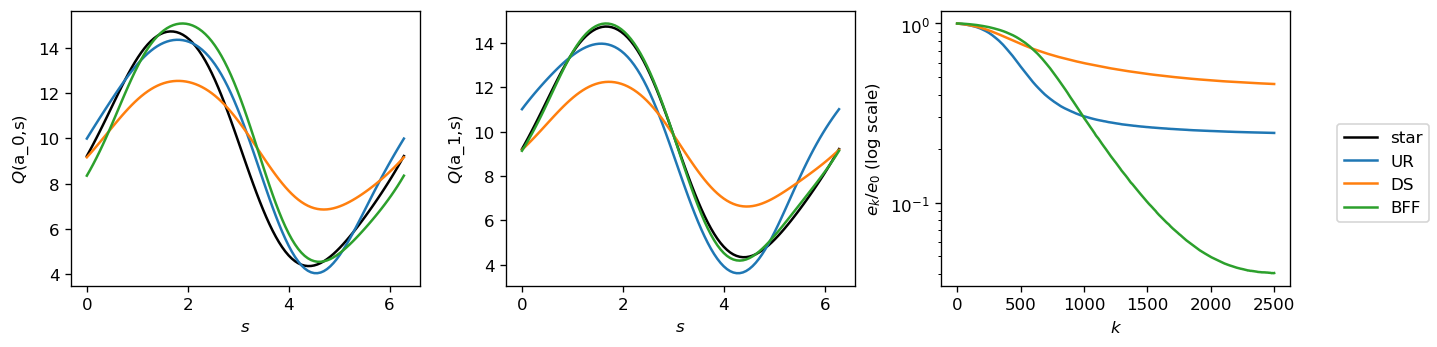

In [80]:
Q_ls = [Q_UR,Q_DS,Q_BFF]
e_ls = [e_UR,e_DS,e_BFF]
labels = ["UR","DS","BFF"]
n = len(labels)
a_n = len(a_s)
fig, axs = plt.subplots(figsize=(12,3),ncols=a_n+1)
x_ls = torch.linspace(0,2*np.pi,100)
y_star_ls = Q_star(x_ls.view(-1,1))
y_ls = torch.cat([Q(x_ls.view(-1,1)).view(1,-1,a_n) for Q in Q_ls])
y_ls -= torch.mean(y_ls-y_star_ls.expand(n,-1,a_n),axis=1).view(n,-1,a_n)
for i in range(a_n):
    axs[i].plot(x_ls.detach().numpy(),y_star_ls[:,1].detach().numpy(),label="star", color="black")
    axs[i].set_ylabel(r"$Q$"+f"(a_{i},s)")
    axs[i].set_xlabel(r"$s$")

for j in range(n):
    for i in range(a_n):
        axs[i].plot(x_ls.detach().numpy(),y_ls[j,:,i].detach().numpy(),label=labels[j])
    axs[a_n].plot(e_ls[j]/e_ls[j][0], label=labels[j])
axs[a_n].set_yscale("log")
axs[a_n].set_ylabel(r"$e_k/e_0$ (log scale)")
axs[a_n].set_xlabel(r"$k$")
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
plt.tight_layout()
plt.subplots_adjust(right=0.9)

### $Q$-control

Fixed behaviour policy to genearte training trajectory, $\pi(a|s)=1/|\mathbb A|$.

$$j^{ctrl}(s_m, a_m, s_m+1;\theta) = r(s_{m+1}, s_m, a_m)  + \gamma \max_{a'} Q^\pi(s_{m+1},a';\theta) - Q^\pi(s_m,a_m;\theta)$$

In [24]:
π = lambda a, s: torch.tensor([1/2.,1/2.])*torch.ones_like(s)
σ = 0.2
ϵ = 2.*np.pi/32.
s_0 = torch.tensor([0.])
r = lambda s: torch.sin(s)+1
a_s = torch.tensor([-1.,1.])

In [25]:
# S, A_idx = sample_policy(s_0, π, σ, ϵ, a_s, int(1e6))
# R = r(S) 
# S_long, A_idx_long = sample_policy(s_0, π, σ, ϵ, a_s, int(1e7))
# R_long = r(S_long) 

In [26]:
# torch.save(S_long, 'S_long_2.pt')
# torch.save(A_idx_long, 'A_idx_long_2.pt')
# torch.save(R_long, 'R_long_2.pt')
# torch.save(S, 'S_2.pt')
# torch.save(A_idx, 'A_idx_2.pt')
# torch.save(R, 'R_2.pt')

In [27]:
S_long = torch.load('S_long_2.pt')
R_long = torch.load('R_long_2.pt')
A_idx_long = torch.load('A_idx_long_2.pt')
S = torch.load('S_2.pt')
R = torch.load('R_2.pt')
A_idx = torch.load('A_idx_2.pt')

In [28]:
# plt.plot(S,".",markersize=0.2);
# plt.xlabel(r"$i$");
# plt.ylabel(r"$s_i$");
# plt.show();
# plt.plot(torch.remainder(S,2*np.pi),".",markersize=0.2,alpha=0.2);
# plt.xlabel(r"$i$");
# plt.ylabel(r"$s_i$");
# plt.show();
# plt.plot(R,".",markersize=0.3,alpha=0.2);
# plt.xlabel(r"$i$");
# plt.ylabel(r"$R(s_i)$");
# plt.show();
# plt.plot(A_idx.view(-1),torch.remainder(S,2*np.pi).view(-1),".",markersize=0.3,alpha=0.01);
# plt.xlabel(r"$a_i$");
# plt.ylabel(r"$s_i$");
# plt.show();

#### SGD

In [29]:
def Q_ctrl_SGD_DS(Q_net, M, epochs,γ,τ_k, S, A_idx, R, Q_net_comp=None, n=100):
    Rem = torch.tensor([])
    N = S.size()[0]
    if Q_net_comp:
        x_ls = torch.linspace(0,2*np.pi,n+1)[:-1].view(-1,1)
        e = [comp(Q_net,Q_net_comp,x_ls, n)]
    for k in trange(epochs, leave=False,desc="Epoch"):
        B, Rem = gen_batches(N-1,M, Rem)
        τ = τ_k(k)
        for i,B_θ in enumerate(tqdm(B,leave=False,desc="Batch")): 
            s = S[B_θ]
            r = R[B_θ].view(-1)
            a_idx = A_idx[B_θ].type(torch.LongTensor).view(-1)
            s_1 = S[B_θ+1]
            q = Q_net(s)[np.arange(M),a_idx]
            j = r + γ*torch.max(Q_net(s_1),axis=1).values - q
            Q_net.zero_grad()
            j.backward(j)
            with torch.no_grad():
                for param in Q_net.parameters():
                    param -= τ/M*param.grad
            if Q_net_comp:
                e.append(comp(Q_net,Q_net_comp,x_ls, n))
    if Q_net_comp:
        return Q_net, torch.tensor(e)
    else:
        return Q_net

In [30]:
def Q_ctrl_SGD_UR(Q_net, M, epochs,γ,τ_k, S,A_idx, R, a_s, π,σ,ϵ, Q_net_comp=None, n=100):
    Rem = torch.tensor([])
    N = S.size()[0]
    if Q_net_comp:
        x_ls = torch.linspace(0,2*np.pi,n+1)[:-1].view(-1,1)
        e = [comp(Q_net,Q_net_comp,x_ls, n)]
    for k in trange(epochs, leave=False,desc="Epoch"):
        B, Rem = gen_batches(N-1,M, Rem)
        τ = τ_k(k)
        for i,B_θ in enumerate(tqdm(B,leave=False,desc="Batch")): 
            s = S[B_θ]
            r = R[B_θ].view(-1)
            a_idx = A_idx[B_θ].type(torch.LongTensor).view(-1)
            s_1 = S[B_θ+1]
            â = torch.tensor([Categorical(probs=π_).sample() for π_ in π(a_s,s)]).view(*s.size())*2 - 1
            ŝ_1 = s+â*ϵ+σ*np.sqrt(ϵ)*torch.normal(mean=torch.zeros_like(s))
            q = Q_net(s)[np.arange(M),a_idx]
#             print(Q_net(s_1).size())
#             print(torch.max(Q_net(s_1),dim=1)..size())
            j = r + γ*torch.max(Q_net(s_1),axis=1).values - q
            ĵ = r + γ*torch.max(Q_net(ŝ_1),axis=1).values - q
            Q_net.zero_grad()
            ĵ.backward(j)
            with torch.no_grad():
                for param in Q_net.parameters():
                    param -= τ/M*param.grad
            if Q_net_comp:
                e.append(comp(Q_net,Q_net_comp,x_ls, n))
    if Q_net_comp:
        return Q_net, torch.tensor(e)
    else:
        return Q_net

In [31]:
def Q_ctrl_SGD_BFF(Q_net, M, epochs,γ,τ_k, S, A_idx, R, Q_net_comp=None, n=100):
    Rem = torch.tensor([])
    N = S.size()[0]
    if Q_net_comp:
        x_ls = torch.linspace(0,2*np.pi,n+1)[:-1].view(-1,1)
        e = [comp(Q_net,Q_net_comp,x_ls, n)]
    for k in trange(epochs, leave=False,desc="Epoch"):
        B, Rem = gen_batches(N-2,M, Rem)
        τ = τ_k(k)
        for i,B_θ in enumerate(tqdm(B,leave=False,desc="Batch")): 
            s = S[B_θ]
            r = R[B_θ].view(-1)
            a_idx = A_idx[B_θ].type(torch.LongTensor).view(-1)
            s_1 = S[B_θ+1]
            s_2 = S[B_θ+2]
            s̃_1 = s+s_2-s_1
            q = Q_net(s)[np.arange(M),a_idx]
            j = r + γ*torch.max(Q_net(s_1),axis=1).values - q
            j̃ = r + γ*torch.max(Q_net(s̃_1),axis=1).values - q
            Q_net.zero_grad()
            j̃.backward(j)
            with torch.no_grad():
                for param in Q_net.parameters():
                    param -= τ/M*param.grad
            if Q_net_comp:
                e.append(comp(Q_net,Q_net_comp,x_ls, n))
    if Q_net_comp:
        return Q_net, torch.tensor(e)
    else:
        return Q_net

In [15]:
Q_star = Net()
M = int(1e4)
epochs = 3
γ = 0.9
τ_k = lambda k: 0.025*0.95**k

In [23]:
# Q_star = Q_ctrl_SGD_UR(Q_star, M, epochs,γ,τ_k, S_long, A_idx_long, R_long, a_s, π,σ,ϵ)

In [24]:
# torch.save(Q_star, "Q_ctrl_star.pt")

In [38]:
Q_star = torch.load("Q_ctrl_star.pt")

In [17]:
M = int(1e4)
epochs = 15
τ_k = lambda k: 0.15*0.95**k

In [32]:
Q_UR = Net()
Q_UR, e_UR = Q_ctrl_SGD_UR(Q_UR, M, epochs,γ,τ_k, S, A_idx, R, a_s, π,σ,ϵ,Q_star)
Q_DS = Net()
Q_DS, e_DS = Q_ctrl_SGD_DS(Q_DS, M, epochs,γ,τ_k, S, A_idx, R,Q_star)
Q_BFF = Net()
Q_BFF, e_BFF = Q_ctrl_SGD_BFF(Q_BFF, M, epochs,γ,τ_k, S, A_idx, R,Q_star)

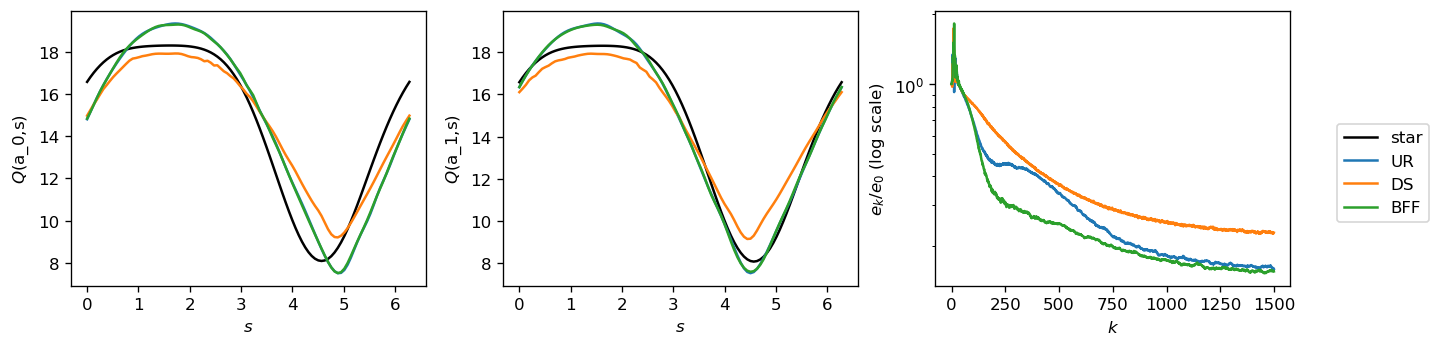

In [31]:
Q_ls = [Q_UR,Q_DS,Q_BFF]
e_ls = [e_UR,e_DS,e_BFF]
labels = ["UR","DS","BFF"]
n = len(labels)
a_n = len(a_s)
fig, axs = plt.subplots(figsize=(12,3),ncols=a_n+1)
x_ls = torch.linspace(0,2*np.pi,100)
y_star_ls = Q_star(x_ls.view(-1,1))
y_ls = torch.cat([Q(x_ls.view(-1,1)).view(1,-1,a_n) for Q in Q_ls])
y_ls -= torch.mean(y_ls-y_star_ls.expand(n,-1,a_n),axis=1).view(n,-1,a_n)
for i in range(a_n):
    axs[i].plot(x_ls.detach().numpy(),y_star_ls[:,1].detach().numpy(),label="star", color="black")
    axs[i].set_ylabel(r"$Q$"+f"(a_{i},s)")
    axs[i].set_xlabel(r"$s$")
for j in range(n):
    for i in range(a_n):
        axs[i].plot(x_ls.detach().numpy(),y_ls[j,:,i].detach().numpy(),label=labels[j])
    axs[a_n].plot(e_ls[j]/e_ls[j][0], label=labels[j])
axs[a_n].set_yscale("log")
axs[a_n].set_ylabel(r"$e_k/e_0$ (log scale)")
axs[a_n].set_xlabel(r"$k$")
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
plt.tight_layout()
plt.subplots_adjust(right=0.9)

#### CBO

In [33]:
def Q_ctrl_CBO_DS(Q_net, Q_s, S,A_idx, R, M, m, epochs, γ, λ, τ_k, η_k, β_k, Q_net_comp=None, n=100):
    with torch.no_grad():
        Rem = torch.tensor([])
        L = torch.empty(M)
        N = len(Q_s)
        n = S.size()[0]
        if Q_net_comp:
            x_ls = torch.linspace(0,2*np.pi,n+1)[:-1].view(-1,1)
            e = [comp(Q_net,Q_net_comp,x_ls, n)]
        for k in trange(epochs, leave=False,desc="Epoch"):
            B, Rem = gen_batches(N,M, Rem)
            η = η_k(k)
            τ = τ_k(k)
            β = β_k(k)
            for i,B_θ in enumerate(tqdm(B,leave=False,desc="Batch")): 
                A_θ = torch.randperm(n-1)[:m]                
                s = S[A_θ]
                r = R[A_θ].view(-1)
                a_idx = A_idx[A_θ].type(torch.LongTensor).view(-1)
                s_1 = S[A_θ+1]
                Q_θ = [Q_j for j,Q_j in enumerate(Q_s) if j in B_θ]
                j = torch.cat([(r + γ*torch.max(Q_j(s_1),axis=1).values - Q_j(s)[np.arange(m),a_idx]).view(-1,1) for Q_j in Q_θ],1)
                L = torch.sum(j**2,0)/(2*m)
                mu = torch.exp(-β*L)
                for xX in zip(Q_net.parameters(),*[Q_j.parameters() for Q_j in Q_θ]):
                    xX_tensor = torch.cat([xX_j.view(1,-1) for xX_j in xX])
                    x_new = xX_tensor[0]
                    X_new = xX_tensor[1:]
                    x_new = mu.view(1,-1).mm(X_new)/torch.sum(mu)
                    X_new += -λ*η*(X_new-x_new)+τ*np.sqrt(η)*torch.normal(torch.zeros(X_new.size()))*(X_new-x_new)
                    xX_new = torch.cat((x_new,X_new)).view(-1, *xX[0].size())
                    for xX_j, xX_new_j in zip(xX,xX_new):
                        xX_j +=  xX_new_j - xX_j
                if Q_net_comp:
                    e.append(comp(Q_net,Q_net_comp,x_ls, n))
        if Q_net_comp:
            return Q_net, torch.tensor(e)
        else:
            return Q_net

In [34]:
def Q_ctrl_CBO_UR(Q_net, Q_s, S,A_idx, R, a_s, π,σ,ϵ, M, m, epochs, γ, λ, τ_k, η_k, β_k, Q_net_comp=None, n=100):
    with torch.no_grad():
        Rem = torch.tensor([])
        L = torch.empty(M)
        N = len(Q_s)
        n = S.size()[0]
        if Q_net_comp:
            x_ls = torch.linspace(0,2*np.pi,n+1)[:-1].view(-1,1)
            e = [comp(Q_net,Q_net_comp,x_ls, n)]
        for k in trange(epochs, leave=False,desc="Epoch"):
            B, Rem = gen_batches(N,M, Rem)
            η = η_k(k)
            τ = τ_k(k)
            β = β_k(k)
            for i,B_θ in enumerate(tqdm(B,leave=False,desc="Batch")): 
                A_θ = torch.randperm(n-1)[:m]                
                s = S[A_θ]
                r = R[A_θ].view(-1)
                a_idx = A_idx[A_θ].type(torch.LongTensor).view(-1)
                s_1 = S[A_θ+1]
                â = torch.tensor([Categorical(probs=π_).sample() for π_ in π(a_s,s)]).view(*s.size())*2 - 1
                ŝ_1 = s+â*ϵ+σ*np.sqrt(ϵ)*torch.normal(mean=torch.zeros_like(s))
                Q_θ = [Q_j for j,Q_j in enumerate(Q_s) if j in B_θ]
                j = torch.cat([(r + γ*torch.max(Q_j(s_1),axis=1).values - Q_j(s)[np.arange(m),a_idx]).view(-1,1) for Q_j in Q_θ],1)
                ĵ = torch.cat([(r + γ*torch.max(Q_j(ŝ_1),axis=1).values - Q_j(s)[np.arange(m),a_idx]).view(-1,1) for Q_j in Q_θ],1)
                L = torch.sum(j*ĵ,0)/(2*m)
                mu = torch.exp(-β*L)
                for xX in zip(Q_net.parameters(),*[Q_j.parameters() for Q_j in Q_θ]):
                    xX_tensor = torch.cat([xX_j.view(1,-1) for xX_j in xX])
                    x_new = xX_tensor[0]
                    X_new = xX_tensor[1:]
                    x_new = mu.view(1,-1).mm(X_new)/torch.sum(mu)
                    X_new += -λ*η*(X_new-x_new)+τ*np.sqrt(η)*torch.normal(torch.zeros(X_new.size()))*(X_new-x_new)
                    xX_new = torch.cat((x_new,X_new)).view(-1, *xX[0].size())
                    for xX_j, xX_new_j in zip(xX,xX_new):
                        xX_j +=  xX_new_j - xX_j
                if Q_net_comp:
                    e.append(comp(Q_net,Q_net_comp,x_ls, n))
        if Q_net_comp:
            return Q_net, torch.tensor(e)
        else:
            return Q_net

In [35]:
def Q_ctrl_CBO_BFF(Q_net, Q_s, S,A_idx, R, M, m, epochs, γ, λ, τ_k, η_k, β_k, Q_net_comp=None, n=100):
    with torch.no_grad():
        Rem = torch.tensor([])
        L = torch.empty(M)
        N = len(Q_s)
        n = S.size()[0]
        if Q_net_comp:
            x_ls = torch.linspace(0,2*np.pi,n+1)[:-1].view(-1,1)
            e = [comp(Q_net,Q_net_comp,x_ls, n)]
        for k in trange(epochs, leave=False,desc="Epoch"):
            B, Rem = gen_batches(N,M, Rem)
            η = η_k(k)
            τ = τ_k(k)
            β = β_k(k)
            for i,B_θ in enumerate(tqdm(B,leave=False,desc="Batch")): 
                A_θ = torch.randperm(n-2)[:m]                
                s = S[A_θ]
                r = R[A_θ].view(-1)
                a_idx = A_idx[A_θ].type(torch.LongTensor).view(-1)
                s_1 = S[A_θ+1]
                s_2 = S[A_θ+2]
                s̃_1 = s+s_2-s_1
                Q_θ = [Q_j for j,Q_j in enumerate(Q_s) if j in B_θ]
                j = torch.cat([(r + γ*torch.max(Q_j(s_1),axis=1).values - Q_j(s)[np.arange(m),a_idx]).view(-1,1) for Q_j in Q_θ],1)
                j̃ = torch.cat([(r + γ*torch.max(Q_j(s̃_1),axis=1).values - Q_j(s)[np.arange(m),a_idx]).view(-1,1) for Q_j in Q_θ],1)
                L = torch.sum(j*j̃,0)/(2*m)
                mu = torch.exp(-β*L)
                for xX in zip(Q_net.parameters(),*[Q_j.parameters() for Q_j in Q_θ]):
                    xX_tensor = torch.cat([xX_j.view(1,-1) for xX_j in xX])
                    x_new = xX_tensor[0]
                    X_new = xX_tensor[1:]
                    x_new = mu.view(1,-1).mm(X_new)/torch.sum(mu)
                    X_new += -λ*η*(X_new-x_new)+τ*np.sqrt(η)*torch.normal(torch.zeros(X_new.size()))*(X_new-x_new)
                    xX_new = torch.cat((x_new,X_new)).view(-1, *xX[0].size())
                    for xX_j, xX_new_j in zip(xX,xX_new):
                        xX_j +=  xX_new_j - xX_j
                if Q_net_comp:
                    e.append(comp(Q_net,Q_net_comp,x_ls, n))
        if Q_net_comp:
            return Q_net, torch.tensor(e)
        else:
            return Q_net

In [108]:
N = int(1e2)
M = int(1e2)
m = int(1e4)
epochs = 100
λ = 1.
γ = 0.9
η_k = lambda k: 0.01
τ_k = lambda k: 20
β_k = lambda k: 10

In [109]:
Q_s = [Net() for _ in range(N)]
Q_CBO_DS, e_CBO_DS = Q_ctrl_CBO_DS(Net(), Q_s, S,A_idx, R, M, m, epochs, γ, λ, τ_k, η_k, β_k, Q_net_comp=Q_star, n=100)

In [110]:
Q_s = [Net() for _ in range(N)]
Q_CBO_UR, e_CBO_UR = Q_ctrl_CBO_UR(Net(), Q_s, S,A_idx, R,a_s, π,σ,ϵ, M, m, epochs, γ, λ, τ_k, η_k, β_k, Q_net_comp=Q_star, n=100)

In [111]:
Q_s = [Net() for _ in range(N)]
Q_CBO_BFF, e_CBO_BFF = Q_ctrl_CBO_BFF(Net(), Q_s, S,A_idx, R, M, m, epochs, γ, λ, τ_k, η_k, β_k, Q_net_comp=Q_star, n=100)

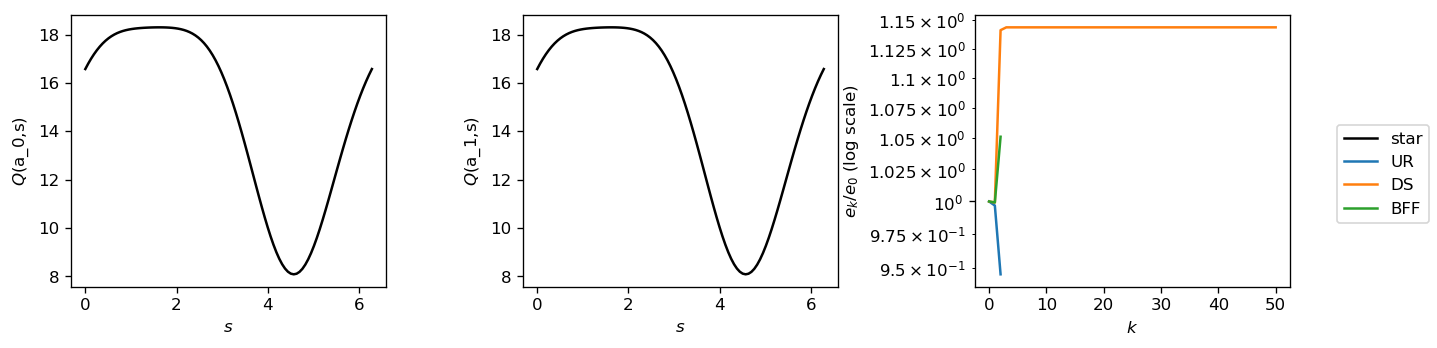

In [107]:
Q_ls = [Q_CBO_UR,Q_CBO_DS,Q_CBO_BFF]
e_ls = [e_CBO_UR,e_CBO_DS,e_CBO_BFF]
labels = ["UR","DS","BFF"]
n = len(labels)
a_n = len(a_s)
fig, axs = plt.subplots(figsize=(12,3),ncols=a_n+1)
x_ls = torch.linspace(0,2*np.pi,100)
y_star_ls = Q_star(x_ls.view(-1,1))
y_ls = torch.cat([Q(x_ls.view(-1,1)).view(1,-1,a_n) for Q in Q_ls])
y_ls -= torch.mean(y_ls-y_star_ls.expand(n,-1,a_n),axis=1).view(n,-1,a_n)
for i in range(a_n):
    axs[i].plot(x_ls.detach().numpy(),y_star_ls[:,1].detach().numpy(),label="star", color="black")
    axs[i].set_ylabel(r"$Q$"+f"(a_{i},s)")
    axs[i].set_xlabel(r"$s$")

for j in range(n):
    for i in range(a_n):
        axs[i].plot(x_ls.detach().numpy(),y_ls[j,:,i].detach().numpy(),label=labels[j])
    axs[a_n].plot(e_ls[j]/e_ls[j][0], label=labels[j])
axs[a_n].set_yscale("log")
axs[a_n].set_ylabel(r"$e_k/e_0$ (log scale)")
axs[a_n].set_xlabel(r"$k$")
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
plt.tight_layout()
plt.subplots_adjust(right=0.9)